In this notebook we will provide a simple example of using FORCE learning (Sussillo and Abbott, 2009) to train an RNN to produce a sine wave. We will use principle components analysis to compute the dimensionality of the RNN activity. Further below, we will train the RNN to produce a fixed point and will test whether it is locally stable against perturbations in the RNN activity. We will also test some of the assumptions made in the mean-field theory of Mastrogiuseppe and Ostojic (2019).

-J.M. Murray, jm4347@columbia.edu, May 2019

In [3]:
from pylab import *
%matplotlib inline

## Use FORCE learning to train an RNN to produce a sine wave

In [6]:
# First define parameters.

# Number of units:
n = 500

# Gain parameter, which adjusts the strength of recurrent weights:
g = 1.5

# Recurrent connectivity matrix:
j = g*np.random.randn(n,n)/n**0.5

# Time step (where the RNN time constant tau=1):
dt = 0.1

# Array of times:
tRange = np.arange(0, 500, dt)

# Desired output that I want to train the network to replicate:
f = np.sin(0.25*tRange)

# The vector feeding the output z(t) back into the network is fixed and random:
wFB = np.random.randn(n)

# Constant input to the network:
wIn = np.random.randn(n)
bIn = 0.0

# The activity matrix, which starts from a random configuration; x[t,j] is the 
# activity of neuron j at time step t:
x = np.zeros((len(tRange), n))
x[0] = np.random.randn(n)

# The inverse learning rate (Sussillo and Abbott suggest alpha ~ 1 to 100):
alpha = 1.

# The regularized inverse correlation matrix; p[t, :, :] is the nxn matrix at 
# time step t:
p = np.eye(n)/alpha

# The output, which I want to resemble f(t):
z = np.zeros(len(tRange))

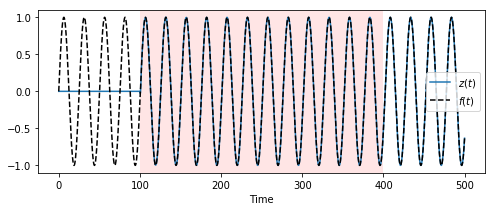

In [3]:
# Initialize the readout weights:
w = np.zeros(n)

# The main loop, which evolves everything in time (note t here is an integer, not actual time):
for t in range(len(tRange)-1):
    x[t+1] = (1-dt)*x[t] + dt*(np.dot(j, np.tanh(x[t])) + bIn*wIn + z[t]*wFB)
    rP = np.dot(p, np.tanh(x[t+1]))
    p = p - np.outer(rP, rP)/(1 + np.dot(np.tanh(x[t+1]), rP))
    err = f[t+1] - np.dot(w, np.tanh(x[t+1]))
    
    # Use FORCE learning to adjust the weights, turning it on after some time and turning it off
    # for testing at the end:
    if t > 0.2*len(tRange) and t < 0.8*len(tRange):
        dw = err*np.dot(p, np.tanh(x[t+1]))
        w = w + dw
    
    z[t+1] = np.dot(w, tanh(x[t+1]))

# Plot the network output z, together with the desired output f; the shading shows where learning is turned on:
plt.figure(figsize=(8,3))
plt.axvspan(0.2*tRange[-1], 0.8*tRange[-1], facecolor=(1,0,0), alpha=0.1)
plt.plot(tRange, z)
plt.plot(tRange, f, '--k')
plt.xlabel('Time')
plt.legend(('$z(t)$', '$f(t)$'))

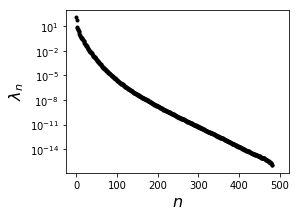

In [4]:
# Do principle components analysis by taking the eigendecomposition of the RNN activity correlation matrix during the testing phase:
r_test = np.tanh(x[int(0.8*tRange[-1]):])
r_mean = np.mean(r_test, axis=0)
r_meansub = r_test - r_mean
evals, evecs = eig(np.dot(r_meansub.T, r_meansub)/len(r_meansub))
evals, evecs = real(evals), real(evecs)  # evals may have a tiny imaginary part that we can ignore

# Sort the eigenvalues from largest to smallest, and sort the eigenvectors to match:
evecs_sorted = evecs[:,argsort(evals)[-1:0:-1]]
evals_sorted = sort(evals)[-1:0:-1]

# Plot the spectrum of eigenvalues from largest to smallest:
plt.figure(figsize=(4,3))
plt.semilogy(evals_sorted, '.k')
plt.xlabel('$n$', fontsize=16);
plt.ylabel('$\lambda_n$', fontsize=16);

In [5]:
# Compute the dimensionality from the PCA spectrum using the participation ratio.

d = np.sum(evals)**2/np.sum(evals**2)
print('PCA dimension:', d)

PCA dimension: 2.386693049508537


Exercise: Try plotting the projections of the mean-subtracted RNN activity along the first two PC vectors (evecs_sorted[:,0] and evecs_sorted[:,1]).

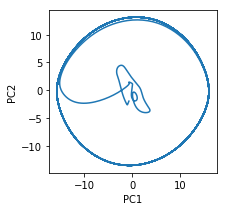

In [6]:
# Plot the first two principle components.

r1 = np.dot(r_meansub, evecs_sorted[:,0])
r2 = np.dot(r_meansub, evecs_sorted[:,1])

plt.figure(figsize=(3,3))
plt.plot(r1, r2)
plt.xlabel('PC1');
plt.ylabel('PC2');

## Use FORCE learning to learn a fixed point

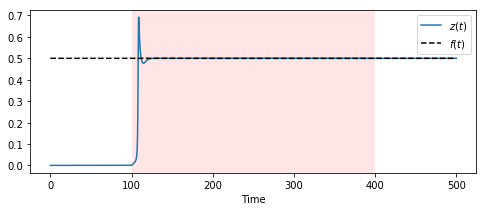

In [20]:
n = 2



# Array of times:
tRange = np.arange(0, 500, dt)

# Recurrent connectivity matrix:
j = g*np.random.randn(n,n)/n**0.5

# The vector feeding the output z(t) back into the network is fixed and random:
wFB = np.random.randn(n)

# Constant input to the network:
wIn = np.random.randn(n)

# The activity matrix, which starts from a random configuration; x[t,j] is the 
# activity of neuron j at time step t:
x = np.zeros((len(tRange), n))
x[0] = np.random.randn(n)

# The output, which I want to resemble f(t):
z = np.zeros(len(tRange))

# New target function:
f = 0.5*np.ones_like(tRange)

# Give the RNN a constant input:
bIn = 0.5

# Initialize the readout weights and P matrix:
w = np.zeros(n)
p = np.eye(n)/alpha

# The main loop, which evolves everything in time (note t here is an integer, not actual time):
for t in range(len(tRange)-1):
    x[t+1] = (1-dt)*x[t] + dt*(np.dot(j, np.tanh(x[t])) + bIn*wIn + z[t]*wFB)
    rP = np.dot(p, np.tanh(x[t+1]))
    p = p - np.outer(rP, rP)/(1 + np.dot(np.tanh(x[t+1]), rP))
    err = f[t+1] - np.dot(w, np.tanh(x[t+1]))
    
    # Use FORCE learning to adjust the weights, turning it on after some time and turning it off
    # for testing at the end:
    if t > 0.2*len(tRange) and t < 0.8*len(tRange):
        dw = err*np.dot(p, np.tanh(x[t+1]))
        w = w + dw
    
    z[t+1] = np.dot(w, tanh(x[t+1]))

# Plot the network output z, together with the desired output f; the shading shows where learning is turned on:
plt.figure(figsize=(8,3))
plt.axvspan(0.2*tRange[-1], 0.8*tRange[-1], facecolor=(1,0,0), alpha=0.1)
plt.plot(tRange, z)
plt.plot(tRange, f, '--k')
plt.xlabel('Time')
plt.legend(('$z(t)$', '$f(t)$'))

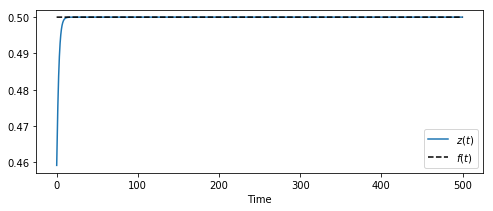

In [21]:
# Check that the fixed point is locally stable by perturbing the RNN state and running the RNN without learning.

x[0] = x[-1] + 0.1*np.random.randn(n)

for t in range(len(tRange)-1):
    x[t+1] = (1-dt)*x[t] + dt*(np.dot(j, np.tanh(x[t])) + bIn*wIn + z[t]*wFB)        
    z[t+1] = np.dot(w, tanh(x[t+1]))

# Plot the network output z, together with the desired output f; the shading shows where learning is turned on:
plt.figure(figsize=(8,3))
plt.plot(tRange[1:], z[1:])
plt.plot(tRange, f, '--k')
plt.xlabel('Time')
plt.legend(('$z(t)$', '$f(t)$'))

### Orientation of the readout weight vector

**Exercise**: In their theory, Mastrogiuseppe and Ostojic predict that the trained readout weight vector should lie in the plane spanned by the input weight vector and the feedback weight vector. Check whether this occurs for the RNN trained above.

In [22]:
w_ = w/norm(w)  # unit vector along w

print('Projection of w_ along wFB: ', np.dot(w_, wFB/norm(wFB)))
print('Projection of w_ along wIn: ', np.dot(w_, wIn/norm(wIn)))

# the component of wIn perpendicular to wFB:
wIn_perp = wIn - np.dot(wIn, wFB/norm(wFB))

print('Magnitude of the component of w_ that _doesn\'t_ lie in the plane spanned by wFB and wIn: ', 
      norm(w_ - w_*np.dot(w_, wFB/norm(wFB)) - w_*np.dot(w_, wIn_perp/norm(wIn_perp))))

Projection of w_ along wFB:  0.964188553934
Projection of w_ along wIn:  0.0789041575099
Magnitude of the component of w_ that _doesn't_ lie in the plane spanned by wFB and wIn:  0.307363559475


These results suggest that a significant component of the readout weight vector lies outside of the plane spanned by wFB and wIn. A more careful analysis would check whether the magnitude of this component becomes small as $N \to \infty$.

### Scaling of the readout weights

**Exercise**: In their theory, Mastrogiuseppe and Ostojic assume that the readout weights scale as $\sim 1/N$ as $N \to \infty$, where $N$ is the RNN size. Check whether this is true in a trained RNN by running the RNN with different values of $N$ and comparing the magnitudes of the readout weights.

In order to check how the trained readout weights scale with the RNN size $N$, we can note that the mean of the readout weights is roughly zero, so the standard deviation gives the typical magnitude of the readout weights. Running the RNN once with N=500 and once with N=2000, I get np.std(w) = 0.0158 and 0.00648, respectively. Since the ratio of these is 2.4, it suggests that the scaling may be closer to $1/\sqrt{N}$ (which would give a ratio of 2) than to $1/N$ (which would give a ratio of 4). A more careful analysis would use more and larger values of $N$.

### Fixed points may be unstable if input vectors are degenerate

Mastrogiuseppe and Ostojic (2019) showed that, if the input and feedback vectors to the RNN are aligned and for target output values lying within a certain range and with weak recurrent connectivity, the RNN fails to learn the correct fixed point or the fixed point becomes unstable (see their Figs. 7 and 8). Here we'll show an example of this happening.

**Exercise**: Try changing the above simulation so that 
- g=0.3 (RNN connectivity strength)
- The input and feedback weights are equal to one another
- The RNN has a nonzero external input (e.g. bIn = 0.1)
- The target output has a constant value in the instability range given by Mastrogiuseppe and Ostojic (roughly -0.2 < f < -0.1)

Does the RNN learn the correct fixed point in this case? Is it stable to perturbations?

In [23]:
# Train for more timesteps to give the RNN a fair chance at learning:
tRange = np.arange(0, 1000, dt)

# Initialize activity vector:
x = np.zeros((len(tRange), n))
x[0] = np.random.randn(n)

# Initialize the output, which I want to resemble f(t):
z = np.zeros(len(tRange))

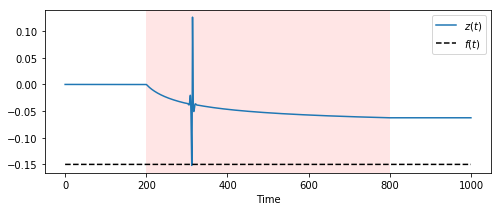

In [44]:
# Align the input weights with the feedback weights:
wIn = wFB

# Recurrent connectivity matrix:
j = 0.3*np.random.randn(n,n)/n**0.5

# Give the RNN a constant input:
bIn = 0.1

# New target function:
f = -0.15*np.ones_like(tRange)

# Initialize the readout weights and P matrix:
w = np.zeros(n)
p = np.eye(n)/alpha

# The main loop, which evolves everything in time (note t here is an integer, not actual time):
for t in range(len(tRange)-1):
    x[t+1] = (1-dt)*x[t] + dt*(np.dot(j, np.tanh(x[t])) + bIn*wIn + z[t]*wFB)
    rP = np.dot(p, np.tanh(x[t+1]))
    p = p - np.outer(rP, rP)/(1 + np.dot(np.tanh(x[t+1]), rP))
    err = f[t+1] - np.dot(w, np.tanh(x[t+1]))
    
    # Use FORCE learning to adjust the weights, turning it on after some time and turning it off
    # for testing at the end:
    if t > 0.2*len(tRange) and t < 0.8*len(tRange):
        dw = err*np.dot(p, np.tanh(x[t+1]))
        w = w + dw
    
    z[t+1] = np.dot(w, tanh(x[t+1]))

# Plot the network output z, together with the desired output f; the shading shows where learning is turned on:
plt.figure(figsize=(8,3))
plt.axvspan(0.2*tRange[-1], 0.8*tRange[-1], facecolor=(1,0,0), alpha=0.1)
plt.plot(tRange, z)
plt.plot(tRange, f, '--k')
plt.xlabel('Time')
plt.legend(('$z(t)$', '$f(t)$'))

It looks like the RNN was unable to learn the target fixed point, as the theory predicted.